In [2]:
from utils.load_datasets import load_dataset
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
dataset_name = "CAVIAR-o"

In [5]:
(xtr, ytr_bit, ytr_deg), (xval, yval_bit, yval_deg), (xte, yte_bit, yte_deg) = load_dataset(dataset_name,
                                                                                            'data//CAVIAR-o.pkl.gz')

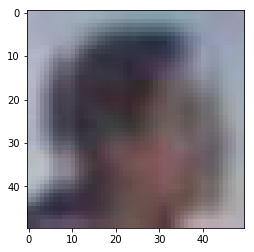

In [11]:
plt.imshow(xtr[2])